# Predicting Vaccination: Modeling Seasonal

Analysis by Corey Hanson & Frank Flavell

![](img/pred_vacc_model_seas.png)

## Table of Contents<span id="0"></span>

1. [**Train/ Test Split, Class Imbalance & Standardization**](#1)
    * User Defined Function for splitting, standardizing and correcting class imbalance
    * Train/test set relabeling
2. [**Logisitic Regression**](#2)
    * Baseline
    * Optimized Models
3. [**K-Nearest Neighbor**](#3)
    * Baseline
    * Determine Best K
    * Optimized Model
4. [**Decision Tree**](#4)
    * Baseline
    * Determine Best Depth
    * Optimized Model
5. [**Random Forest**](#5)
    * Baseline
    * GridSearch
    * Optimized Model
6. [**AdaBoost**](#6)
    * Baseline
    * GridSearch
    * Optimized Model
7. [**Gradient Boosting**](#7)
    * Baseline
    * GridSearch
    * Optimized Models
8. [**XGBoost**](#8)
    * Baseline
    * GridSearch
    * Optimized Models
9. [**Best Model**](#9)
    * Analysis
    * Recommendations
    

# Package Import

In [81]:
!pip install imblearn
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import TomekLinks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from cleaning_functions import *
from eda import *
from sklearn.model_selection import cross_val_score
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *
from sklearn.preprocessing import StandardScaler

# Data Import and Review

In [82]:
df = pd.read_pickle('data.pickle')

In [83]:
pd.set_option('display.max_columns', None)
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,homeowner,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55_to_64 Years,< 12 Years,White,Female,Below Poverty,Not Married,1.0,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35_to_44 Years,12 Years,White,Male,Below Poverty,Not Married,0.0,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18_to_34 Years,College Graduate,White,Male,Above Poverty,Not Married,1.0,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1,1,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,Over_65,12 Years,White,Female,Below Poverty,Not Married,0.0,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45_to_54 Years,Some College,White,Female,Above Poverty,Married,1.0,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0,1,0,0,0,0


In [84]:
df.shape

(26707, 43)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26707 non-null  float64
 1   h1n1_knowledge               26707 non-null  float64
 2   behavioral_antiviral_meds    26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_face_mask         26707 non-null  float64
 5   behavioral_wash_hands        26707 non-null  float64
 6   behavioral_large_gatherings  26707 non-null  float64
 7   behavioral_outside_home      26707 non-null  float64
 8   behavioral_touch_face        26707 non-null  float64
 9   doctor_recc_h1n1             26707 non-null  float64
 10  doctor_recc_seasonal         26707 non-null  float64
 11  chronic_med_condition        26707 non-null  float64
 12  child_under_6_months         26707 non-null  float64
 13  health_worker   

In [86]:
df.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,homeowner,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,1.619800,1.261392,0.048714,0.727749,0.068933,0.825888,0.357472,0.336279,0.678811,0.202494,0.303067,0.272962,0.080054,0.108548,0.934998,3.852810,2.337589,2.352380,4.025536,2.705321,2.115737,0.777998,0.887558,0.529599,0.212454,0.465608,0.080878,0.459580,0.076459,0.009323,0.026398,0.065114
std,0.909016,0.617047,0.215273,0.445127,0.253345,0.379213,0.479264,0.472444,0.466942,0.401866,0.459592,0.445490,0.271382,0.311077,0.246533,1.000195,1.276825,1.353339,1.077131,1.375216,1.319585,0.415600,0.749980,0.925264,0.409052,0.498825,0.272652,0.498373,0.265737,0.096108,0.160318,0.246732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,5.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# <span id="1"></span>1. Train/ Test Split, Class Imbalance & Standardization
#### [Return Contents](#0)
<hr/>

During EDA, we determined that there was a class imblance for the H1N1 Vaccination target variable.  To correct this imbalance, we downsampled the majority class so that our models would run faster during training.

The user-defined class below creates an object, 'data', that houses the original dataframe as well as any transformations we added including dummy variables, scaling, class imbalance correction and ploynomial features.  It also takes care of the train/test split.

In [87]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]
untr = ['household_adults', 'household_children',]
nom = df.columns.drop([*untr, *binary_columns, *target_cols, *missing_dummies])

#The dicts that come into the arguments.
categorical = {
    "nominal_features":nom, "standard_dummies": binary_columns, "impute_dummies":missing_dummies
}

continuous = {"untransformed":untr}
polynomial = {"method":"choose", "columns":['age_group', 'education', 'sex',
                                            'doctor_recc_seasonal', 'income_poverty']}

In [88]:
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class='downsample', scale_type=False, poly_degree=2)
data.column_drop(data.cols_polynomial)
data.column_drop(['age_group_65+ Years education_College Graduate',
       'age_group_65+ Years sex_Male',
       'doctor_recc_seasonal age_group_45 - 54 Years',
       'doctor_recc_seasonal education_Some College',
       'doctor_recc_seasonal income_poverty_unknown',
       'doctor_recc_seasonal sex_Male'], reverse=True)
data.get_df()


Creating Dummies
Getting polynomial features of degree 2

['age_group_35_to_44 Years age_group_45_to_54 Years', 'age_group_35_to_44 Years age_group_55_to_64 Years', 'age_group_35_to_44 Years age_group_Over_65', 'age_group_45_to_54 Years age_group_55_to_64 Years', 'age_group_45_to_54 Years age_group_Over_65', 'age_group_55_to_64 Years age_group_Over_65', 'education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College', 'income_poverty_Above Poverty income_poverty_Below Poverty', 'income_poverty_Above Poverty income_poverty_unknown', 'income_poverty_Below Poverty income_poverty_unknown']
were removed for containing 0 values

Performing downsample
No scaling specified
Skipping scaling
Adding ['doctor_recc_seasonal^2', 'doctor_recc_seasonal age_group_35_to_44 Years', 'doctor_recc_seasonal age_group_45_to_54 Years', 'doctor_recc_seasonal age_group_55_to_64 Years', 'doctor_recc_seasonal age_group_Over_65', '

,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,homeowner,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_sick_from_vacc_2.0,opinion_h1n1_sick_from_vacc_3.0,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,age_group_35_to_44 Years,age_group_45_to_54 Years,age_group_55_to_64 Years,age_group_Over_65,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,income_poverty_Above Poverty,income_poverty_Below Poverty,income_poverty_unknown,marital_status_Not Married,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_unknown,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,doctor_recc_seasonal education_Some College,doctor_recc_seasonal sex_Male,doctor_recc_seasonal income_poverty_unknown,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24982,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,1
12299,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [89]:
data.df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,homeowner,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55_to_64 Years,< 12 Years,White,Female,Below Poverty,Not Married,1.0,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35_to_44 Years,12 Years,White,Male,Below Poverty,Not Married,0.0,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18_to_34 Years,College Graduate,White,Male,Above Poverty,Not Married,1.0,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1,1,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,Over_65,12 Years,White,Female,Below Poverty,Not Married,0.0,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45_to_54 Years,Some College,White,Female,Above Poverty,Married,1.0,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,5.0,2.0,2.0,Over_65,Some College,White,Female,Above Poverty,Not Married,1.0,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,1,0,0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18_to_34 Years,College Graduate,White,Male,Above Poverty,Not Married,0.0,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0,0,0,0,0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,5.0,4.0,2.0,55_to_64 Years,Some College,White,Female,unknown,Not Married,1.0,Employed,lzgpxyit,"MSA, Not Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,1


## Train/ Test Set Labeling

DataFrame with the dummy variables and the downsample class imblanace correction.

In [90]:
df2 = data.get_df()

In [91]:
X_train_reg = data.get_X_train()
y_train_reg = data.y_train

X_test_reg = data.get_X_test()
y_test_reg = data.y_test

# X_train_sel_reg = X_train.loc[:,select_features]
# y_train_sel_reg = y_train

# X_test_sel_reg = X_test.loc[:,select_features]
# y_test_sel_reg = y_test

In [92]:
target = target_col2

reg_features = df2.columns.drop(target)

scaled_features = extract_column_names(df2, "_scaled$")

select_features = ['doctor_recc_h1n1', 'opinion_h1n1_vacc_effective_5.0', 'missing_health_insurance', 'opinion_h1n1_risk_4.0', 'opinion_h1n1_risk_5.0', 'household_adults', 'health_worker', 'marital_status_Not Married']

select_features_scaled = ['doctor_recc_h1n1_scaled', 'opinion_h1n1_vacc_effective_5.0_scaled', 'missing_health_insurance_scaled', 'opinion_h1n1_risk_4.0_scaled', 'opinion_h1n1_risk_5.0_scaled', 'household_adults_scaled', 'health_worker_scaled', 'marital_status_Not Married_scaled']


In [93]:
df2.head()

,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,homeowner,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_sick_from_vacc_2.0,opinion_h1n1_sick_from_vacc_3.0,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,age_group_35_to_44 Years,age_group_45_to_54 Years,age_group_55_to_64 Years,age_group_Over_65,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,income_poverty_Above Poverty,income_poverty_Below Poverty,income_poverty_unknown,marital_status_Not Married,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_unknown,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,doctor_recc_seasonal education_Some College,doctor_recc_seasonal sex_Male,doctor_recc_seasonal income_poverty_unknown,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24982,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,1
12299,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

# Standardization

In [94]:
scaler = StandardScaler()
subset_scaled = []
for var in reg_features:
    new_col = var +"_scaled"
    X_train_reg[new_col] = scaler.fit_transform(X_train_reg[[var]])
    X_test_reg[new_col] = scaler.transform(X_test_reg[[var]])
    subset_scaled.append(new_col)

In [95]:
X_train_scaled = X_train_reg[extract_column_names(X_train_reg, "_scaled$")]
y_train_scaled = y_train_reg

X_test_scaled = X_test_reg[extract_column_names(X_test_reg, "_scaled$")]
y_test_scaled = y_test_reg

In [96]:
full_df = pd.concat([X_train_reg, X_test_reg], axis=0)

In [97]:
full_y = pd.concat([y_train_reg, y_test_reg], axis=0)

# Selected Features

In [98]:
X_train_sel_reg = X_train_reg[select_features]
y_train_sel_reg = y_train_reg

X_test_sel_reg = X_test_reg[select_features]
y_test_sel_reg = y_test_reg

X_train_sel_scaled = X_train_reg[select_features_scaled]
y_train_sel_scaled = y_train_reg

X_test_sel_scaled = X_test_reg[select_features_scaled]
y_test_sel_scaled = y_test_reg

# Instantiating the Evaluation DataFrame

In [99]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Accuracy':[],
                           'Precision':[],
                           'FP':[],
                           'Recall':[],
                           'FN':[],
                           'F1-Score':[],
                           'AUC':[]})

# <span id="2"></span>2. Logistic Regression
#### [Return Contents](#0)
<hr/>

# Logistic Regression Baseline

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report 
from sklearn import metrics

#---------------------------------------------------------------------------------------------

# Logisitic Regression 1: All Features, Not Scaled
logreg1 = LogisticRegression().fit(X_train_reg,y_train_reg)
y_pred1 = logreg1.predict(X_test_reg)

cm = metrics.confusion_matrix(y_test_reg, y_pred1)
print('Logisitic Regression 1: All Features, Not Scaled')
print('Confusion Matrix :')
print(cm)
print('Test Accuracy Score :',metrics.accuracy_score(y_test_reg, y_pred1))
print('Report : ')
print(classification_report(y_test_reg, y_pred1))

acc = float(format(metrics.accuracy_score(y_test_reg, y_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_reg, y_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_reg, y_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_reg, y_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_reg, y_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-1','all features, not scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Logisitic Regression 1: All Features, Not Scaled
Confusion Matrix :
[[2292  583]
 [ 558 1909]]
Test Accuracy Score : 0.7864095844253088
Report : 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2875
           1       0.77      0.77      0.77      2467

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.77


# Logistic Regression Optimizations

In [21]:
# Logisitic Regression 2: All Features, Scaled
logreg2 = LogisticRegression().fit(X_train_scaled,y_train_scaled)
y_pred2 = logreg2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred2)
print('Logisitic Regression 2: All Features, Scaled')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred2))
print('Report : ')
print(classification_report(y_test_scaled, y_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-2','all features, scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression 3: Select Features, Not Scaled
logreg3 = LogisticRegression().fit(X_train_sel_reg,y_train_sel_reg)
y_pred3 = logreg3.predict(X_test_sel_reg)

cm = metrics.confusion_matrix(y_test_scaled, y_pred3)
print('Logisitic Regression 3: Select Features, Not Scaled')
print('Confusion Matrix :')
print(cm)
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred3))
print('Report : ')
print(classification_report(y_test_scaled, y_pred3))

acc = float(format(metrics.accuracy_score(y_test_reg, y_pred3, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_reg, y_pred3),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_reg, y_pred3),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_reg, y_pred3),'.3f'))
f1 = float(format(metrics.f1_score(y_test_reg, y_pred3),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-3','select features, not scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled
logreg4 = LogisticRegression().fit(X_train_sel_scaled,y_train_sel_scaled)
y_pred4 = logreg4.predict(X_test_sel_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred4)
print('Logisitic Regression 4: Select Features, Scaled')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred4))
print('Report : ')
print(classification_report(y_test_scaled, y_pred4))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred4, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred4),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred4),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred4),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred4),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-4','select features, scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled, Poly Degree 2
from sklearn.preprocessing import PolynomialFeatures
polyfeat = PolynomialFeatures(degree=2)
X_trainpoly = polyfeat.fit_transform(X_train_sel_scaled)
X_testpoly = polyfeat.fit_transform(X_test_sel_scaled)
logreg5 = LogisticRegression().fit(X_trainpoly,y_train_sel_scaled)
y_pred5 = logreg5.predict(X_testpoly)

cm = metrics.confusion_matrix(y_test_scaled, y_pred5)
print('Logisitic Regression 5: Select Features, Scaled, Poly 2')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred5))
print('Report : ')
print(classification_report(y_test_scaled, y_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred5, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred5),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred5),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred5),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred5),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-5','select features, scaled, poly 2',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled, Poly Degree 3
polyfeat = PolynomialFeatures(degree=3)
X_trainpoly = polyfeat.fit_transform(X_train_sel_scaled)
X_testpoly = polyfeat.fit_transform(X_test_sel_scaled)
logreg6 = LogisticRegression().fit(X_trainpoly,y_train_sel_scaled)
y_pred6 = logreg6.predict(X_testpoly)

cm = metrics.confusion_matrix(y_test_scaled, y_pred6)
print('Logisitic Regression 5: Select Features, Scaled, Poly 3')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred6))
print('Report : ')
print(classification_report(y_test_scaled, y_pred6))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred6, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred6),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred6),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred6),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred6),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-6','select features, scaled, poly 3',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Logisitic Regression 2: All Features, Scaled
Confusion Matrix :
[[2292  583]
 [ 558 1909]]
Test Accuracy Score : 0.7864095844253088
Report : 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2875
           1       0.77      0.77      0.77      2467

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342

Logisitic Regression 3: Select Features, Not Scaled
Confusion Matrix :
[[1999  876]
 [1036 1431]]
Test Accuracy Score : 0.6420816173717708
Report : 
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      2875
           1       0.62      0.58      0.60      2467

    accuracy                           0.64      5342
   macro avg       0.64      0.64      0.64      5342
weighted avg       0.64      0.64      0.64      5342

Logisitic Regression 4: Select Features, Scaled
Confusi

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594
4,Logistic Regression-5,"select features, scaled, poly 2",0.643,0.633,772.0,0.540,1134.0,0.636,0.583


# <span id="3"></span>3. K-Nearest Neighbor (K-NN)
#### [Return Contents](#0)
<hr/>

# Baseline K-NN

In [22]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Instantiate KNeighborsClassifier
knn1 = KNeighborsClassifier()
# Fit the classifier
knn1.fit(X_train_scaled, y_train_scaled)
# Predict on the test set
y_pred_knn1 = knn1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred_knn1)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred_knn1))
print('Report : ')
print(classification_report(y_test_scaled, y_pred_knn1))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred_knn1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred_knn1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred_knn1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred_knn1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred_knn1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['K-Nearest Neighbor','baseline K=1',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[1957  918]
 [ 764 1703]]
Test Accuracy Score : 0.6851366529389742
Report : 
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2875
           1       0.65      0.69      0.67      2467

    accuracy                           0.69      5342
   macro avg       0.68      0.69      0.68      5342
weighted avg       0.69      0.69      0.69      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594
4,Logistic Regression-5,"select features, scaled, poly 2",0.643,0.633,772.0,0.540,1134.0,0.636,0.583


# KNN Optimization

In [23]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = metrics.f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [24]:
find_best_k(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, min_k=1, max_k=11)

Best Value for k: 11
F1-Score: 0.688283270340163


In [25]:
# search for an optimal value of K for KNN
k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_scaled)
    y_predict = knn.predict(X_test_scaled)
    score = metrics.f1_score(y_test_scaled, y_predict, average='weighted')
    k_scores.append(score)
print(k_scores)

[0.6473376747383437, 0.6670287058556144, 0.6644721807600926, 0.6774057539572248, 0.6855692182977251, 0.6973071599051799, 0.7012760685408316, 0.7026351330324855, 0.7028943921437795, 0.7055868967516222]


# KNN Optimized, K = 8

In [26]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Instantiate KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=8)
# Fit the classifier
knn2.fit(X_train_scaled, y_train_scaled)
# Predict on the test set
y_pred_knn2 = knn2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred_knn2)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred_knn2))
print('Report : ')
print(classification_report(y_test_scaled, y_pred_knn2))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred_knn2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred_knn2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred_knn2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred_knn2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred_knn2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['K-Nearest Neighbor','Optimized K=XXX',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2192  683]
 [ 898 1569]]
Test Accuracy Score : 0.7040434294271808
Report : 
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      2875
           1       0.70      0.64      0.66      2467

    accuracy                           0.70      5342
   macro avg       0.70      0.70      0.70      5342
weighted avg       0.70      0.70      0.70      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594
4,Logistic Regression-5,"select features, scaled, poly 2",0.643,0.633,772.0,0.540,1134.0,0.636,0.583


# <span id="4"></span>4. Decision Tree
#### [Return Contents](#0)
<hr/>

# Decision Tree Baseline

In [27]:
# Instantiate and fit a DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dt1 = DecisionTreeClassifier(criterion='gini')

# fit the model
dt1.fit(X_train_scaled, y_train_scaled)
dt_pred1 = dt1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, dt_pred1)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, dt_pred1))
print('Report : ')
print(classification_report(y_test_scaled, dt_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, dt_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, dt_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, dt_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, dt_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, dt_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree-1','Baseline',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[1805 1070]
 [ 657 1810]]
Test Accuracy Score : 0.6767128416323475
Report : 
              precision    recall  f1-score   support

           0       0.73      0.63      0.68      2875
           1       0.63      0.73      0.68      2467

    accuracy                           0.68      5342
   macro avg       0.68      0.68      0.68      5342
weighted avg       0.68      0.68      0.68      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594
4,Logistic Regression-5,"select features, scaled, poly 2",0.643,0.633,772.0,0.540,1134.0,0.636,0.583


# Determine Feature Importance

In [28]:
# Feature importance
importance = pd.DataFrame(dt1.feature_importances_, index=X_train_scaled.columns).reset_index().sort_values(by = 0, ascending=False)
importance.head(8).values

array([['opinion_seas_vacc_effective_5.0_scaled', 0.13862629671694465],
       ['doctor_recc_seasonal_scaled', 0.09092519675505253],
       ['opinion_seas_risk_4.0_scaled', 0.031782392865600584],
       ['age_group_Over_65_scaled', 0.024350856191460227],
       ['household_adults_scaled', 0.020477341741066794],
       ['opinion_seas_risk_5.0_scaled', 0.01979393486788917],
       ['household_children_scaled', 0.015332311885400636],
       ['h1n1_knowledge_2.0_scaled', 0.013118815091875779]], dtype=object)

In [29]:
['doctor_recc_h1n1_scaled', 'opinion_h1n1_vacc_effective_5.0_scaled', 'missing_health_insurance_scaled', 'opinion_h1n1_risk_4.0_scaled', 'opinion_h1n1_risk_5.0_scaled', 'household_adults_scaled', 'health_worker_scaled', 'marital_status_Not Married_scaled']

['doctor_recc_h1n1_scaled',
 'opinion_h1n1_vacc_effective_5.0_scaled',
 'missing_health_insurance_scaled',
 'opinion_h1n1_risk_4.0_scaled',
 'opinion_h1n1_risk_5.0_scaled',
 'household_adults_scaled',
 'health_worker_scaled',
 'marital_status_Not Married_scaled']

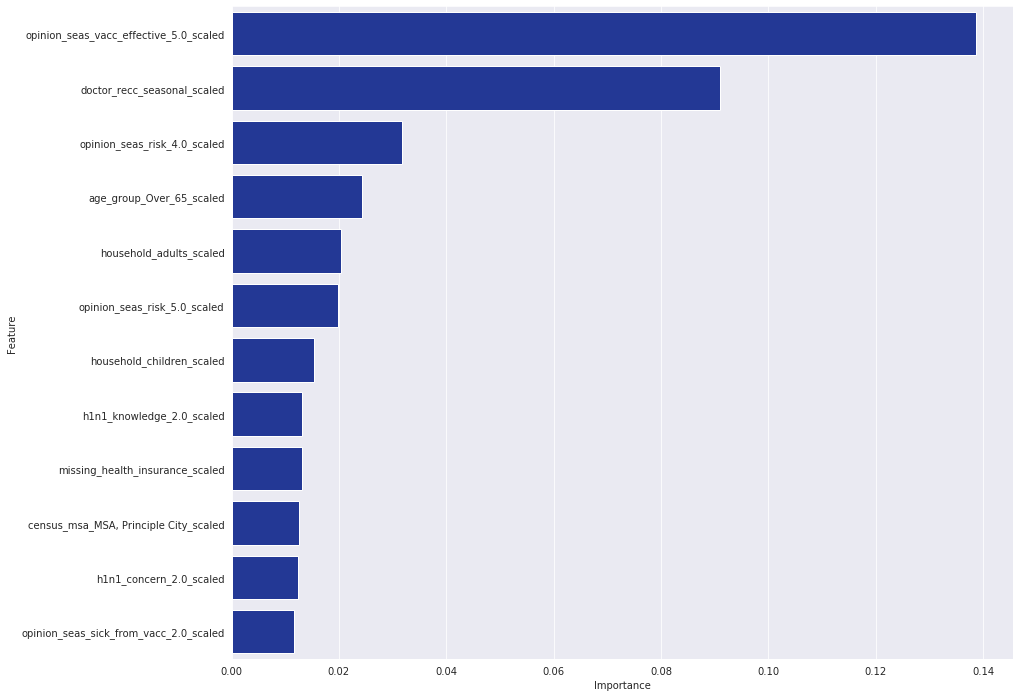

In [30]:
# Feature importance Graph
pal = sns.color_palette(("#102CA8",))
show_feature_importances(dt1, X_train_scaled, figsize=(14, 12), palette=pal, font_scale=1, ascending=False, rows=12, style="darkgrid")


# Determine Ideal Depth

[0.6807781885913571, 0.7262237175534632, 0.7264243193588793, 0.7262741950456336, 0.7439302859670056, 0.756571004712155, 0.7580259212551121, 0.7632925739848087, 0.7620386114450701]


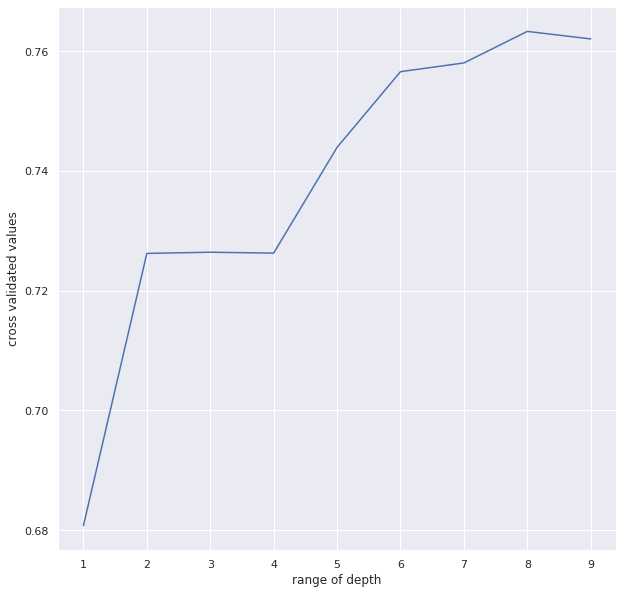

In [31]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(dt1, X_train_reg, y_train_reg, cv = 5)
score.mean()
depth_range = range(1,10)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, X_train_reg, y_train_reg, cv = 5)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

# Optimized Decision Tree: Depth 6

In [32]:
# Instantiate and fit a DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=6)

# fit the model
dt2.fit(X_train_scaled, y_train_scaled)
dt_pred2 = dt2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, dt_pred2)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, dt_pred2))
print('Report : ')
print(classification_report(y_test_scaled, dt_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, dt_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, dt_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, dt_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, dt_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, dt_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree-2','Optimized: Depth 6',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2164  711]
 [ 616 1851]]
Test Accuracy Score : 0.7515911643579184
Report : 
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      2875
           1       0.72      0.75      0.74      2467

    accuracy                           0.75      5342
   macro avg       0.75      0.75      0.75      5342
weighted avg       0.75      0.75      0.75      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594
4,Logistic Regression-5,"select features, scaled, poly 2",0.643,0.633,772.0,0.540,1134.0,0.636,0.583


# Decision Tree: Depth 6 with Poly Features Degree 3

In [33]:
from sklearn.preprocessing import PolynomialFeatures
polyfeat = PolynomialFeatures(degree=3)
X_trainpoly = polyfeat.fit_transform(X_train_sel_scaled)
X_testpoly = polyfeat.fit_transform(X_test_sel_scaled)

from sklearn.tree import DecisionTreeClassifier
dt3 = DecisionTreeClassifier(criterion='gini', max_depth=6)

# fit the model
dt3.fit(X_trainpoly, y_train_scaled)
# Predictions
dt_pred3 = dt3.predict(X_testpoly)

cm = metrics.confusion_matrix(y_test_scaled, dt_pred3)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, dt_pred3))
print('Report : ')
print(classification_report(y_test_scaled, dt_pred3))

acc = float(format(metrics.accuracy_score(y_test_scaled, dt_pred3, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, dt_pred3),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, dt_pred3),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, dt_pred3),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, dt_pred3),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree-3','Optimized: Depth 3, Poly Degree 3',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2003  872]
 [1109 1358]]
Test Accuracy Score : 0.6291651067016099
Report : 
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2875
           1       0.61      0.55      0.58      2467

    accuracy                           0.63      5342
   macro avg       0.63      0.62      0.62      5342
weighted avg       0.63      0.63      0.63      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594
4,Logistic Regression-5,"select features, scaled, poly 2",0.643,0.633,772.0,0.540,1134.0,0.636,0.583


# <span id="5"></span>5. Random Forest
#### [Return Contents](#0)
<hr/>

# Baseline Random Forest

In [34]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
forest1 = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest1.fit(X_train_scaled, y_train_scaled)
forest_pred1 = forest1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, forest_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, forest_pred1))
print('Report : ')
print(classification_report(y_test_scaled, forest_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, forest_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, forest_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, forest_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, forest_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, forest_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Random Forest-1','Baseline',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)


Confusion Matrix :
[[2178  697]
 [ 601 1866]]
Accuracy Score : 0.7570198427555223
Report : 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2875
           1       0.73      0.76      0.74      2467

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
11,Random Forest-1,Baseline,0.757,0.728,697.0,0.756,601.0,0.757,0.742
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594


# Random Forest Optimization: GridSearch

In [35]:
param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [ 2, 5, 10],
    'min_samples_leaf': [2, 3, 5, 7]
}

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#Instantiate the gridsearch object
rf_grid_search = GridSearchCV(forest1, param_grid, cv=3)

# Fit to the data
rf_grid_search.fit(X_train_reg, y_train_reg)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

# Optimized Random Forest

In [36]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
forest2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False)
forest2.fit(X_train_scaled, y_train_scaled)
forest_pred2 = forest1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, forest_pred2)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, forest_pred2))
print('Report : ')
print(classification_report(y_test_scaled, forest_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, forest_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, forest_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, forest_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, forest_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, forest_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Random Forest-2','Optimized Hyperparameters',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2178  697]
 [ 601 1866]]
Accuracy Score : 0.7570198427555223
Report : 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2875
           1       0.73      0.76      0.74      2467

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
11,Random Forest-1,Baseline,0.757,0.728,697.0,0.756,601.0,0.757,0.742
12,Random Forest-2,Optimized Hyperparameters,0.757,0.728,697.0,0.756,601.0,0.757,0.742
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599


# <span id="6"></span>6. AdaBoost
#### [Return Contents](#0)
<hr/>

# AdaBoost Baseline

In [37]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)
ada1 = adaboost_clf.fit(X_train_scaled, y_train_scaled)
ada_pred1 = ada1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, ada_pred1)
print('Confusion Matrix :')
print(cm)
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, ada_pred1))
print('Report : ')
print(classification_report(y_test_scaled, ada_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, ada_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, ada_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, ada_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, ada_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, ada_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['AdaBoost-1','Baseline',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)


Confusion Matrix :
[[2304  571]
 [ 582 1885]]
Accuracy Score : 0.7841632347435418
Report : 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2875
           1       0.77      0.76      0.77      2467

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
13,AdaBoost-1,Baseline,0.784,0.768,571.0,0.764,582.0,0.783,0.766
11,Random Forest-1,Baseline,0.757,0.728,697.0,0.756,601.0,0.757,0.742
12,Random Forest-2,Optimized Hyperparameters,0.757,0.728,697.0,0.756,601.0,0.757,0.742
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599


# AdaBoost Optimization: GridSearch

In [38]:
param_grid = {
    "learning_rate": [0.1, 0.2],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=5)],
    'n_estimators': [5, 30, 100, 250],
}

ada_clf = AdaBoostClassifier(random_state=42)
grid_ada = GridSearchCV(ada_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_ada.fit(X_train_scaled, y_train_scaled)

best_parameters = grid_ada.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_ada.predict(X_train_scaled)
val_preds = grid_ada.predict(X_test_scaled)
training_accuracy = accuracy_score(y_train_scaled, training_preds)
val_accuracy = accuracy_score(y_test_scaled, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
base_estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
learning_rate: 0.1
n_estimators: 250

Training Accuracy: 88.38%
Validation accuracy: 75.07%


# AdaBoost Optimized

In [39]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)
ada2 = adaboost_clf.fit(X_train_scaled, y_train_scaled)
ada_pred2 = ada2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, ada_pred2)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, ada_pred2))
print('Report : ')
print(classification_report(y_test_scaled, ada_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, ada_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, ada_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, ada_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, ada_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, ada_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['AdaBoost-2','Optimized',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2304  571]
 [ 582 1885]]
Accuracy Score : 0.7841632347435418
Report : 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2875
           1       0.77      0.76      0.77      2467

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
13,AdaBoost-1,Baseline,0.784,0.768,571.0,0.764,582.0,0.783,0.766
14,AdaBoost-2,Optimized,0.784,0.768,571.0,0.764,582.0,0.783,0.766
11,Random Forest-1,Baseline,0.757,0.728,697.0,0.756,601.0,0.757,0.742
12,Random Forest-2,Optimized Hyperparameters,0.757,0.728,697.0,0.756,601.0,0.757,0.742
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665


# <span id="7"></span>7. XGBoost
#### [Return Contents](#0)
<hr/>

# <span id="8"></span>8. XGBoost
#### [Return Contents](#0)
<hr/>

# XGBoost Baseline

In [40]:
X_train_scaled

,household_adults_scaled,household_children_scaled,behavioral_antiviral_meds_scaled,behavioral_avoidance_scaled,behavioral_face_mask_scaled,behavioral_wash_hands_scaled,behavioral_large_gatherings_scaled,behavioral_outside_home_scaled,behavioral_touch_face_scaled,doctor_recc_h1n1_scaled,doctor_recc_seasonal_scaled,chronic_med_condition_scaled,child_under_6_months_scaled,health_worker_scaled,health_insurance_scaled,homeowner_scaled,missing_doctor_recc_scaled,missing_health_insurance_scaled,missing_homeowner_scaled,missing_household_scaled,missing_opinion_scaled,missing_demographics_scaled,h1n1_concern_1.0_scaled,h1n1_concern_2.0_scaled,h1n1_concern_3.0_scaled,h1n1_knowledge_1.0_scaled,h1n1_knowledge_2.0_scaled,opinion_h1n1_vacc_effective_2.0_scaled,opinion_h1n1_vacc_effective_3.0_scaled,opinion_h1n1_vacc_effective_4.0_scaled,opinion_h1n1_vacc_effective_5.0_scaled,opinion_h1n1_risk_2.0_scaled,opinion_h1n1_risk_3.0_scaled,opinion_h1n1_risk_4.0_scaled,opinion_h1n1_risk_5.0_scaled,opinion_h1n1_sick_from_vacc_2.0_scaled,opinion_h1n1_sick_from_vacc_3.0_scaled,opinion_h1n1_sick_from_vacc_4.0_scaled,opinion_h1n1_sick_from_vacc_5.0_scaled,opinion_seas_vacc_effective_2.0_scaled,opinion_seas_vacc_effective_3.0_scaled,opinion_seas_vacc_effective_4.0_scaled,opinion_seas_vacc_effective_5.0_scaled,opinion_seas_risk_2.0_scaled,opinion_seas_risk_3.0_scaled,opinion_seas_risk_4.0_scaled,opinion_seas_risk_5.0_scaled,opinion_seas_sick_from_vacc_2.0_scaled,opinion_seas_sick_from_vacc_3.0_scaled,opinion_seas_sick_from_vacc_4.0_scaled,opinion_seas_sick_from_vacc_5.0_scaled,age_group_35_to_44 Years_scaled,age_group_45_to_54 Years_scaled,age_group_55_to_64 Years_scaled,age_group_Over_65_scaled,education_< 12 Years_scaled,education_College Graduate_scaled,education_Some College_scaled,race_Hispanic_scaled,race_Other or Multiple_scaled,race_White_scaled,sex_Male_scaled,income_poverty_Above Poverty_scaled,income_poverty_Below Poverty_scaled,income_poverty_unknown_scaled,marital_status_Not Married_scaled,employment_status_Not in Labor Force_scaled,employment_status_Unemployed_scaled,hhs_geo_region_bhuqouqj_scaled,hhs_geo_region_dqpwygqj_scaled,hhs_geo_region_fpwskwrf_scaled,hhs_geo_region_kbazzjca_scaled,hhs_geo_region_lrircsnp_scaled,hhs_geo_region_lzgpxyit_scaled,hhs_geo_region_mlyzmhmf_scaled,hhs_geo_region_oxchjgsf_scaled,hhs_geo_region_qufhixun_scaled,"census_msa_MSA, Principle City_scaled",census_msa_Non-MSA_scaled,employment_industry_atmlpfrs_scaled,employment_industry_cfqqtusy_scaled,employment_industry_dotnnunm_scaled,employment_industry_fcxhlnwr_scaled,employment_industry_haxffmxo_scaled,employment_industry_ldnlellj_scaled,employment_industry_mcubkhph_scaled,employment_industry_mfikgejo_scaled,employment_industry_msuufmds_scaled,employment_industry_nduyfdeo_scaled,employment_industry_phxvnwax_scaled,employment_industry_pxcmvdjn_scaled,employment_industry_qnlwzans_scaled,employment_industry_rucpziij_scaled,employment_industry_saaquncn_scaled,employment_industry_unknown_scaled,employment_industry_vjjrobsf_scaled,employment_industry_wlfvacwt_scaled,employment_industry_wxleyezf_scaled,employment_industry_xicduogh_scaled,employment_industry_xqicxuve_scaled,employment_occupation_ccgxvspp_scaled,employment_occupation_cmhcxjea_scaled,employment_occupation_dcjcmpih_scaled,employment_occupation_dlvbwzss_scaled,employment_occupation_emcorrxb_scaled,employment_occupation_haliazsg_scaled,employment_occupation_hfxkjkmi_scaled,employment_occupation_hodpvpew_scaled,employment_occupation_kldqjyjy_scaled,employment_occupation_mxkfnird_scaled,employment_occupation_oijqvulv_scaled,employment_occupation_pvmttkik_scaled,employment_occupation_qxajmpny_scaled,employment_occupation_rcertsgn_scaled,employment_occupation_tfqavkke_scaled,employment_occupation_ukymxvdu_scaled,employment_occupation_unknown_scaled,employment_occupation_uqqtjvyb_scaled,employment_occupation_vlluhbov_scaled,employment_occupation_xgwztkwe_scaled,employment_occupation_xqwwgdyp_scaled,employment_occ

In [41]:
X_train_scaled = X_train_scaled.rename(columns=lambda x: x.replace('<', '_'))

In [42]:
X_test_scaled = X_test_scaled.rename(columns=lambda x: x.replace('<', '_'))

In [43]:
y_train_scaled

respondent_id
24982    1
12299    1
8759     1
23274    1
7471     1
        ..
7668     0
16948    0
1822     0
22623    0
24438    0
Name: seasonal_vaccine, Length: 19936, dtype: int64

In [44]:
import xgboost as xgb
clf1 = xgb.XGBClassifier()
clf1.fit(X_train_scaled, y_train_scaled)
xgb_pred1 = clf1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, xgb_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, xgb_pred1))
print('Report : ')
print(classification_report(y_test_scaled, xgb_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, xgb_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, xgb_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, xgb_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, xgb_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, xgb_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['XGBoosting-1','Baseline',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2154  721]
 [ 503 1964]]
Accuracy Score : 0.770872332459753
Report : 
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2875
           1       0.73      0.80      0.76      2467

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
13,AdaBoost-1,Baseline,0.784,0.768,571.0,0.764,582.0,0.783,0.766
14,AdaBoost-2,Optimized,0.784,0.768,571.0,0.764,582.0,0.783,0.766
15,XGBoosting-1,Baseline,0.771,0.731,721.0,0.796,503.0,0.773,0.762
11,Random Forest-1,Baseline,0.757,0.728,697.0,0.756,601.0,0.757,0.742
12,Random Forest-2,Optimized Hyperparameters,0.757,0.728,697.0,0.756,601.0,0.757,0.742
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669


# XGBoost Optimization: GridSearch

In [45]:
param_grid = {'n_estimators':[100,300,500],
              'learning_rate':[0.1,0.5,0.01],
              'max_depth':[3,5,7],
              'colsample_bytree':[0.5,0.4,0.3],
              'min_child_weight':[1,2,3]
             }

In [46]:
param_grid = {'n_estimators':[100,300,500],
              'learning_rate':[0.1,0.5,0.01],
              'max_depth':[3,5,7],
              'colsample_bytree':[0.5,0.4,0.3],
              'min_child_weight':[1,2,3]
             }

clf_xg = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf_xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_scaled, y_train_scaled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_scaled)
val_preds = grid_clf.predict(X_test_scaled)
training_accuracy = accuracy_score(y_train_scaled, training_preds)
val_accuracy = accuracy_score(y_test_scaled, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
colsample_bytree: 0.3
learning_rate: 0.1
max_depth: 7
min_child_weight: 1
n_estimators: 500

Training Accuracy: 94.94%
Validation accuracy: 77.39%


# XGBoost Optimized

In [51]:
clf2 = xgb.XGBClassifier()
clf2.fit(X_train_scaled, y_train_scaled)
xgb_pred2 = clf2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, xgb_pred2)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, xgb_pred2))
print('Report : ')
print(classification_report(y_test_scaled, xgb_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, xgb_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, xgb_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, xgb_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, xgb_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, xgb_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['XGBoosting-2','Optimized',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2154  721]
 [ 503 1964]]
Accuracy Score : 0.770872332459753
Report : 
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2875
           1       0.73      0.80      0.76      2467

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
14,AdaBoost-2,Optimized,0.784,0.768,571.0,0.764,582.0,0.783,0.766
13,AdaBoost-1,Baseline,0.784,0.768,571.0,0.764,582.0,0.783,0.766
15,XGBoosting-1,Baseline,0.771,0.731,721.0,0.796,503.0,0.773,0.762
16,XGBoosting-2,Optimized,0.771,0.731,721.0,0.796,503.0,0.773,0.762
11,Random Forest-1,Baseline,0.757,0.728,697.0,0.756,601.0,0.757,0.742
12,Random Forest-2,Optimized Hyperparameters,0.757,0.728,697.0,0.756,601.0,0.757,0.742
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677


# Support Vector Machine Baseline

In [52]:
from sklearn.svm import SVC  
svc1 = SVC(kernel='rbf', C=1)  
svc1.fit(X_train_scaled, y_train_scaled) 
svc_pred1 = svc1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, svc_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, svc_pred1))
print('Report : ')
print(classification_report(y_test_scaled, svc_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, svc_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, svc_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, svc_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, svc_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, svc_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['SVC','rbf, c=1',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2173  702]
 [ 520 1947]]
Accuracy Score : 0.7712467240733808
Report : 
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2875
           1       0.73      0.79      0.76      2467

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
14,AdaBoost-2,Optimized,0.784,0.768,571.0,0.764,582.0,0.783,0.766
13,AdaBoost-1,Baseline,0.784,0.768,571.0,0.764,582.0,0.783,0.766
16,XGBoosting-2,Optimized,0.771,0.731,721.0,0.796,503.0,0.773,0.762
15,XGBoosting-1,Baseline,0.771,0.731,721.0,0.796,503.0,0.773,0.762
17,SVC,"rbf, c=1",0.771,0.735,702.0,0.789,520.0,0.773,0.761
11,Random Forest-1,Baseline,0.757,0.728,697.0,0.756,601.0,0.757,0.742
12,Random Forest-2,Optimized Hyperparameters,0.757,0.728,697.0,0.756,601.0,0.757,0.742
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736


fasle positives = predicted that people did vaccinate when they didn't.
false negatives = predicted that people did not vaccinate when they actually did.

The goal is complete vaccination, so we would prefer to predict that someone did not vaccinate when they actually did (False Negative).  Meaning we are ok with many False Nagatives, but far fewer false positives where we predicted that someone had vaccinated when they actually did not.  This way our marketing materials will reach a wider audience of people, even if they already received a vaccination.

By making the model more strict 

A high value of C meaning we are more tolerant of the violation, which in turn might give us a model that has high bias but low variance; however, a low value of C indicates low tolerance of the violation, potentially giving us more variance but less bias.

# <span id="10"></span>10. Best Model
#### [Return Contents](#0)
<hr/>

In [53]:
evaluation

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
1,Logistic Regression-2,"all features, scaled",0.786,0.766,583.0,0.774,558.0,0.786,0.770
2,Logistic Regression-3,"select features, not scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
3,Logistic Regression-4,"select features, scaled",0.642,0.620,876.0,0.580,1036.0,0.638,0.599
4,Logistic Regression-5,"select features, scaled, poly 2",0.643,0.633,772.0,0.540,1134.0,0.636,0.583
5,Logistic Regression-6,"select features, scaled, poly 3",0.643,0.625,839.0,0.567,1069.0,0.637,0.594
6,K-Nearest Neighbor,baseline K=1,0.685,0.650,918.0,0.690,764.0,0.686,0.669
7,K-Nearest Neighbor,Optimized K=XXX,0.704,0.697,683.0,0.636,898.0,0.699,0.665
8,Decision Tree-1,Baseline,0.677,0.628,1070.0,0.734,657.0,0.681,0.677
9,Decision Tree-2,Optimized: Depth 6,0.752,0.722,711.0,0.750,616.0,0.751,0.736


### Model Analysis

In [ ]:
graph confusion matrix

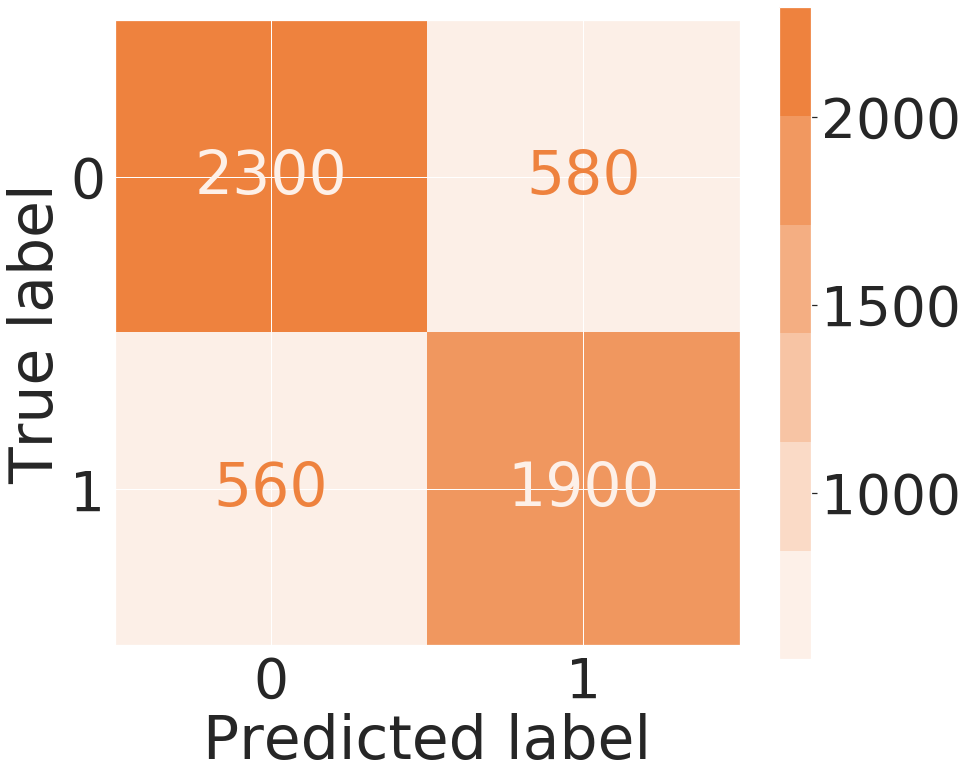

In [55]:
palette = sns.light_palette("#EE823E")
confusion_matrix_graph(logreg2, X_test_scaled, y_test_scaled, font_scale=5, palette=palette)

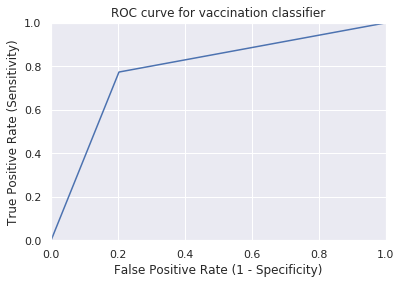

In [104]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test_scaled, logreg2.predict(X_test_scaled))
sns.set(font_scale=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for vaccination classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Recommendations

In [79]:
print_full(pd.Series(logreg2.coef_.ravel(), index=X_test_scaled.columns).sort_values(ascending=False))

opinion_seas_risk_4.0_scaled                          0.766839
opinion_seas_vacc_effective_5.0_scaled                0.747252
opinion_seas_risk_5.0_scaled                          0.684075
age_group_Over_65_scaled                              0.640194
doctor_recc_seasonal_scaled                           0.600974
employment_occupation_unknown_scaled                  0.371229
opinion_seas_risk_2.0_scaled                          0.356844
age_group_55_to_64 Years_scaled                       0.304934
opinion_seas_vacc_effective_4.0_scaled                0.253650
health_worker_scaled                                  0.203242
opinion_seas_risk_3.0_scaled                          0.194279
health_insurance_scaled                               0.168271
age_group_45_to_54 Years_scaled                       0.159957
race_White_scaled                                     0.147351
h1n1_knowledge_2.0_scaled                             0.143461
race_Other or Multiple_scaled                         0

In [80]:
print_full(pd.Series(logreg2.coef_.ravel(), index=X_test_scaled.columns).sort_values(ascending=True))

opinion_seas_sick_from_vacc_5.0_scaled               -0.234683
missing_health_insurance_scaled                      -0.225913
opinion_seas_sick_from_vacc_4.0_scaled               -0.216884
opinion_seas_sick_from_vacc_2.0_scaled               -0.207566
employment_industry_unknown_scaled                   -0.174040
opinion_seas_sick_from_vacc_3.0_scaled               -0.151538
doctor_recc_h1n1_scaled                              -0.144679
employment_industry_rucpziij_scaled                  -0.116676
employment_status_Unemployed_scaled                  -0.115980
employment_industry_ldnlellj_scaled                  -0.111808
employment_status_Not in Labor Force_scaled          -0.111557
opinion_seas_vacc_effective_2.0_scaled               -0.093368
employment_industry_saaquncn_scaled                  -0.091744
employment_industry_nduyfdeo_scaled                  -0.083894
employment_industry_vjjrobsf_scaled                  -0.076581
employment_industry_wxleyezf_scaled                  -0

In the the limited adjustment of hyperparameters, the logistic regression had the best performing model. Based on the strengths of the coeficience it appears that the likelihood of a seasonal vaccine was influenced most by having positive opinions, being over 65 years old, and having a doctor's reccomendation.

Interestingly enough, the next best performing metric was the positive influence of the lack of a presence of an individual's occupation field.